# Packages

In [1]:
# Helpful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import split_vectorize
import base_models

# Import Data

In [2]:
df = pd.read_csv('data/nyt_corpus.csv')
df.shape

(10000, 32)

# Preprocessing

### Labels

In [3]:
# possible labels - desk works best
df[['desk','general_descriptor','online_sections','taxonomic_classifier']][-10:]

,desk,general_descriptor,online_sections,taxonomic_classifier
9990,Editorial Desk,"['Budgets and Budgeting', 'National Debt (US)'...",Opinion,"['Top/Opinion', 'Top/Opinion/Opinion', 'Top/Ne..."
9991,Foreign Desk,"['Immigration and Refugees', 'Jews', 'Music', ...",World,"['Top/News', 'Top/News/World/Countries and Ter..."
9992,Foreign Desk,['Airlines and Airplanes'],NaN,['Top/Classifieds/Job Market/Job Categories/Ma...
9993,Metropolitan Desk,"['Murders and Attempted Murders', 'Basketball'...",New York and Region,"['Top/News/U.S./U.S. States, Territories and P..."
9994,Book Review Desk,['Books and Literature'],Arts; Books,"['Top/Features/Books/Book Reviews', 'Top/Featu..."
9995,Editorial Desk,NaN,Opinion,"['Top/Opinion/Opinion/Letters', 'Top/Opinion',..."
9996,National Desk,NaN,U.S.,"['Top/News/U.S.', 'Top/News']"
9997,Metropolitan Desk,NaN,New York and Region,['Top/News/New York and Region']
9998,Classified,NaN,Paid Death Notices,['Top/Classifieds/Paid Death Notices']
9999,Leisure/Weekend Desk,NaN,Arts,['Top/Features/Arts']


In [4]:
# pct nulls for each possible labels
n = df.shape[0]
(n - df[['desk','general_descriptor','online_sections','taxonomic_classifier']].count())/n

desk                    0.0041
general_descriptor      0.2140
online_sections         0.0244
taxonomic_classifier    0.0144
dtype: float64

In [5]:
# these will be cleaned up for the final dataframe
df.groupby('desk')['desk'].count()[:20]

desk
A Nation Challenged                   1
Adventure Sports                      2
Arts & Ideas/Cultural Desk           18
Arts & Leisure Desk                  29
Arts and Leisure Desk               129
Automobiles                           9
Book Review Desk                    176
Business World Magazine               1
Business/Finance Desk                 1
Business/Financial Desk             628
Business\Financial Desk               1
Cars                                  4
Circuits                             48
Classifed                             1
Classified                          721
Classified Desk                       3
Classifieds                           4
Connecticut Weekly Desk              90
Cultural Desk                       231
Dining In, Dining Out/Style Desk     37
Name: desk, dtype: int64

In [6]:
df_final = pd.read_csv('data/nyt_corpus_cleaned.csv')
print(df_final.shape)
df_final.head()

(10000, 6)


,desk,full_text,lead_paragraph,headline,nouns,lemmas
0,financial,"The Bethlehem Steel Corporation, after report...","The Bethlehem Steel Corporation, after report...",Bethlehem Halts Dividends And Plans Cuts After...,Bethlehem Steel Corporation loss quarter yeste...,"The Bethlehem Steel Corporation , after report..."
1,foreign,Seeking to raise morale at home and improve i...,Seeking to raise morale at home and improve i...,World News Briefs;Iraqis Elect Parliament Pre-...,morale home image Iraq today elections candida...,Seeking to raise morale at home and improve it...
2,editorial,By the time Lord Elgin obtained the authority...,By the time Lord Elgin obtained the authority...,Return the Parthenon Marbles,time Lord Elgin authority pieces stone inscrip...,By the time Lord Elgin obtain the authority to...
3,classified,SPEIER-Claire. Born New York City. Age 70. Gr...,SPEIER-Claire. Born New York City. Age 70. Gr...,"Paid Notice: Deaths SPEIER, CLAIRE",SPEIER-Claire. Born New York City. Age Graduat...,SPEIER-Claire. Born New York City. Age 70. Gra...
4,national,LEAD: The Japanese videotape begins with the ...,LEAD: The Japanese videotape begins with the ...,Not Fit to Import?,LEAD videotape words tables foods. tape inspec...,LEAD : The Japanese videotape begin with the w...


In [7]:
#df[df.desk == 'The Business of Green'][['desk','general_descriptor','online_sections','taxonomic_classifier']][-10:]

### Train/Dev/Test Split and TF-IDF Vectorize

In [44]:
reload(split_vectorize)
#np.random.seed(102)

full_text = split_vectorize.SplitVectorize(df_final, 'full_text', 'Full Text')
full_text.train_test_split()
full_text.tfidf_vectorize()

lead_para = split_vectorize.SplitVectorize(df_final, 'lead_paragraph', 'Lead Paragraph')
lead_para.train_test_split()
lead_para.tfidf_vectorize()

headlines = split_vectorize.SplitVectorize(df_final, 'headline', 'Headlines')
headlines.train_test_split()
headlines.tfidf_vectorize()

nouns = split_vectorize.SplitVectorize(df_final, 'nouns', 'Nouns Only')
nouns.train_test_split()
nouns.tfidf_vectorize()

lemmas = split_vectorize.SplitVectorize(df_final, 'lemmas', 'Lemmatized')
lemmas.train_test_split()
lemmas.tfidf_vectorize()

/Users/carmen/Documents/NLP/w266-final-project/split_vectorize.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = self.df[[self.articles, self.labels]][self.df[self.articles].notnull()][self.df[self.labels].notnull()]


In [47]:
from IPython.display import display, HTML

html = '<table><th>Article Type</th><th>Training Articles</th><th>Training Words</th><th>Training Vocab Size</th>'
html += '<th>Avg. Unique Words per Training Article</th><th>Dev Articles</th><th>Test Articles</th></tr>'

for x in [full_text, lead_para, headlines, nouns, lemmas]:
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, x.tv_train.shape[0], x.train_words_)
    html += '<td>{:,}</td><td>{:,.0f}</td>'.format(x.train_vocab_size_, x.train_avg_unq_words_)
    html += '<td>{:,}</td><td>{:,}</td></tr>'.format(x.tv_dev.shape[0], x.tv_test.shape[0])

html += '</table>'
display(HTML(html))

Full Text,"7,299","4,569,061","84,834",260,512,"1,969"
Lead Paragraph,"7,124","681,378","39,642",61,495,"1,904"
Headlines,"7,415","54,662","11,095",6,513,"2,002"
Nouns Only,"7,298","1,392,882","68,334",119,512,"1,969"
Lemmatized,"7,299","4,569,068","79,248",246,512,"1,969"


# Baseline Models

### Multinomial Naïve Bayes

In [15]:
reload(base_models)
mnb = base_models.MultNB()
mnb.test_models(full_text)
mnb.test_models(lead_para)
mnb.test_models(headlines)
mnb.test_models(nouns)
mnb.test_models(lemmas)

Best Multinomial Naïve Bayes model:
input       Full Text
alpha         0.00781
accuracy      0.68555
Name: 10, dtype: object


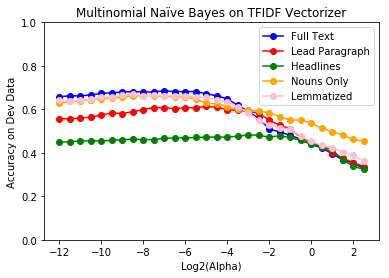

In [17]:
reload(base_models)
mnb_tables = [full_text.mnb_accuracy_table_, lead_para.mnb_accuracy_table_, headlines.mnb_accuracy_table_,
          nouns.mnb_accuracy_table_, lemmas.mnb_accuracy_table_]
mnb.plot_accuracy(mnb_tables)

### Logistic Regression

In [22]:
reload(base_models)
lr = base_models.LogReg()
lr.test_models(full_text)
lr.test_models(lead_para)
lr.test_models(headlines)
lr.test_models(nouns)
lr.test_models(lemmas)

Best Logistic Regression model:
input        Full Text
penalty             L1
C          10.00000000
accuracy    0.75390625
Name: 9, dtype: object


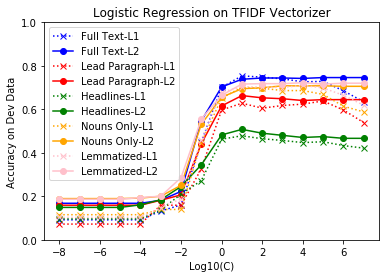

In [26]:
reload(base_models)
lr_tables = [full_text.lr_accuracy_table_, lead_para.lr_accuracy_table_, headlines.lr_accuracy_table_,
             nouns.lr_accuracy_table_, lemmas.lr_accuracy_table_]
lr.plot_accuracy(lr_tables)